<a href="https://colab.research.google.com/github/Borwec/ida_25_26/blob/main/lab3/lab3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms, utils
from torch.utils.data import TensorDataset, DataLoader, Dataset, random_split
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

torch.manual_seed(127)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


Task 1

In [2]:
url = "https://drive.google.com/uc?id=1q96dh1Kdr8DI9nnLsDLntzvdurA2gOA3"
df = pd.read_csv(url)

In [3]:
ohe_cols = ["Soil_Type", "Water_Frequency", "Fertilizer_Type"]
std_cols = ["Sunlight_Hours", "Temperature", "Humidity"]

ohe = OneHotEncoder(sparse_output=False)
std = StandardScaler()

ohe_ft = ohe.fit_transform(df[ohe_cols])
std_ft = std.fit_transform(df[std_cols])

ohe_df = pd.DataFrame(ohe_ft, columns=ohe.get_feature_names_out(ohe_cols))
std_df = pd.DataFrame(std_ft, columns=std.get_feature_names_out(std_cols))

new_df = pd.concat([ohe_df, std_df, df["Growth_Milestone"]], axis=1)

In [4]:
X = new_df.drop(columns=["Growth_Milestone"]).to_numpy()
y = new_df["Growth_Milestone"].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state = 127)

In [5]:
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
X_test  = torch.tensor(X_test,  dtype=torch.float32)
y_test  = torch.tensor(y_test,  dtype=torch.long)

In [6]:
train_data = TensorDataset(X_train, y_train)
test_data  = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader  = DataLoader(test_data,  batch_size=32, shuffle=False)

In [7]:
class SomeMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(12, 64), nn.ReLU(),
            nn.Linear(64, 32), nn.ReLU(),
            nn.Linear(32, 2)
        )

    def forward(self, x):
        logits = self.net(x)
        return logits

In [8]:
model = SomeMLP().to(device)
print(model)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

SomeMLP(
  (net): Sequential(
    (0): Linear(in_features=12, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=2, bias=True)
  )
)


In [9]:
patience = 2
best_val_loss = float('inf')
epochs_no_improve = 0
n_epochs = 30
best_model_path = "best_model.pth"

In [10]:
train_loss_history = []
val_loss_history = []
for epoch in range(n_epochs):

    model.train()
    train_loss = 0.0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            loss = criterion(out, y)
            val_loss += loss.item()
    val_loss /= len(test_loader)

    train_loss_history.append(train_loss)
    val_loss_history.append(val_loss)
    print(f"[{epoch+1:02d}] train_loss={train_loss:.4f} | val_loss={val_loss:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), best_model_path)
        print("Saved best model")
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print("Early stopping epoch: ", epoch)
            break

[01] train_loss=0.6945 | val_loss=0.6902
Saved best model
[02] train_loss=0.6881 | val_loss=0.6884
Saved best model
[03] train_loss=0.6837 | val_loss=0.6871
Saved best model
[04] train_loss=0.6802 | val_loss=0.6857
Saved best model
[05] train_loss=0.6751 | val_loss=0.6839
Saved best model
[06] train_loss=0.6730 | val_loss=0.6816
Saved best model
[07] train_loss=0.6666 | val_loss=0.6792
Saved best model
[08] train_loss=0.6612 | val_loss=0.6764
Saved best model
[09] train_loss=0.6549 | val_loss=0.6741
Saved best model
[10] train_loss=0.6475 | val_loss=0.6709
Saved best model
[11] train_loss=0.6381 | val_loss=0.6680
Saved best model
[12] train_loss=0.6304 | val_loss=0.6655
Saved best model
[13] train_loss=0.6252 | val_loss=0.6630
Saved best model
[14] train_loss=0.6154 | val_loss=0.6603
Saved best model
[15] train_loss=0.6136 | val_loss=0.6585
Saved best model
[16] train_loss=0.5971 | val_loss=0.6543
Saved best model
[17] train_loss=0.5939 | val_loss=0.6500
Saved best model
[18] train_los

In [11]:
best_model = SomeMLP().to(device)
best_model.load_state_dict(torch.load(best_model_path, map_location=device))
best_model.eval()
print("Best model loaded")

Best model loaded


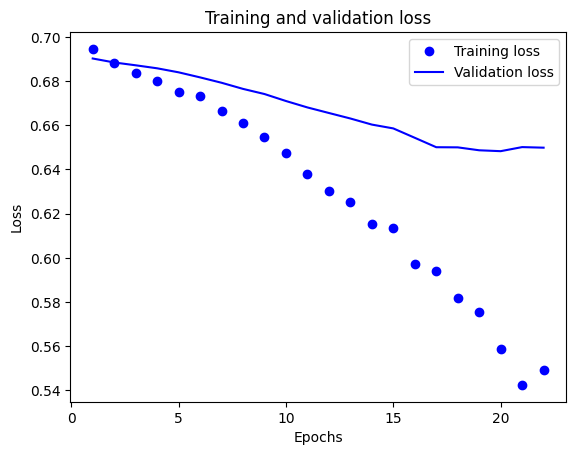

In [12]:
import matplotlib.pyplot as plt
epochs = range(1, len(train_loss_history) + 1)
plt.plot(epochs, train_loss_history, "bo", label="Training loss")
plt.plot(epochs, val_loss_history, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [13]:
model.eval()
correct, total = 0, 0
with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        preds = model(x).argmax(dim=1)
        correct += (preds == y).sum().item()
        total += y.size(0)

print(f"Final Test Accuracy: {correct/total*100:.2f}%")

Final Test Accuracy: 59.18%


Task 2a

In [14]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [15]:
base_path = "/content/drive/MyDrive/ida_25_26/lab3/task2/"

In [16]:
import matplotlib.image as mpimg
class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = self.img_dir + self.img_labels.iloc[idx, 0]
        image = mpimg.imread(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [48]:
train_set = CustomImageDataset(
    annotations_file=base_path+"train.csv",
    img_dir=base_path,
    transform=transforms.ToTensor())

test_set = CustomImageDataset(
    annotations_file=base_path+"test.csv",
    img_dir=base_path,
    transform=transforms.ToTensor())

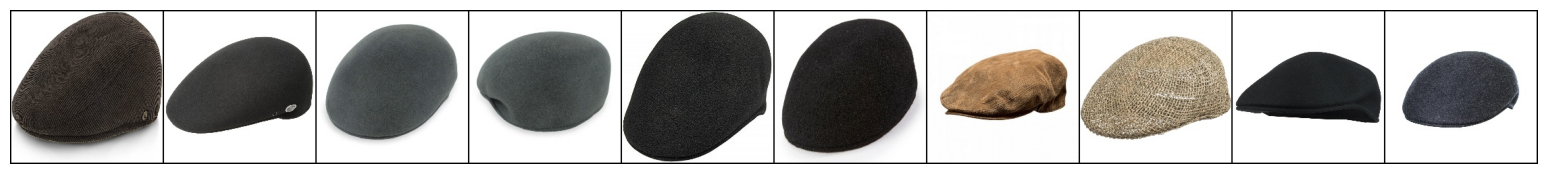

In [35]:
def show_batch(dataset, n=10):
    imgs = [dataset[i][0] for i in range(10)]
    grid = utils.make_grid(imgs, nrow=n, padding=2)
    plt.figure(figsize=(2*n, 2))
    plt.imshow(grid.permute(1, 2, 0))
    plt.axis("off")
    plt.show()

show_batch(train_set, n=10)

In [70]:
train_size = int(0.8 * len(train_set))
test_size = len(train_set) - train_size
train_set, test_set = random_split(train_set, [train_size, test_size])

train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
test_loader = DataLoader(test_set, batch_size=32)

In [71]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool  = nn.MaxPool2d(2,2)
        self.dropout = nn.Dropout(0.25)


        self.fc1 = nn.Linear(64*56*56, 128)
        self.fc2 = nn.Linear(128, 20)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = self.dropout(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        logits = self.fc2(x)
        return logits

model_basic = CNN().to(device)
print(model_basic)

CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.25, inplace=False)
  (fc1): Linear(in_features=200704, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=20, bias=True)
)


In [72]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_basic.parameters(), lr=1e-3)

In [79]:
patience = 2
best_val_loss = float('inf')
epochs_no_improve = 0
n_epochs = 7
best_model_path = "best_model.pth"

train_loss_history = []
val_loss_history = []
for epoch in range(n_epochs):

    model_basic.train()
    train_loss = 0.0
    # for x, y in next(iter(train_loader)):
    x, y = next(iter(train_loader))
    x, y = x.to(device), y.to(device)
    optimizer.zero_grad()
    out = model_basic(x)
    loss = criterion(out, y)
    loss.backward()
    optimizer.step()
    train_loss += loss.item()
    train_loss /= 2

    model_basic.eval()
    val_loss = 0.0
    with torch.no_grad():
        x, y = x.to(device), y.to(device)
        out = model_basic(x)
        loss = criterion(out, y)
        val_loss += loss.item()
    val_loss /= 2

    train_loss_history.append(train_loss)
    val_loss_history.append(val_loss)
    print(f"[{epoch+1:02d}] train_loss={train_loss:.4f} | val_loss={val_loss:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        torch.save(model_basic.state_dict(), best_model_path)
        print("Saved best model")
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print("Early stopping epoch: ", epoch)
            break

[01] train_loss=1.9012 | val_loss=1.6864
Saved best model
[02] train_loss=1.9640 | val_loss=1.7003
[03] train_loss=1.7363 | val_loss=1.5622
Saved best model
[04] train_loss=1.6104 | val_loss=1.5198
Saved best model
[05] train_loss=1.5073 | val_loss=1.4759
Saved best model
[06] train_loss=1.4802 | val_loss=1.4627
Saved best model
[07] train_loss=1.4898 | val_loss=1.4744


In [80]:
model_basic.eval()
correct, total = 0, 0
with torch.no_grad():
    # for x, y in next(iter(test_loader)):
        x, y = next(iter(test_loader))
        x, y = x.to(device), y.to(device)
        preds = model_basic(x).argmax(dim=1)
        correct += (preds == y).sum().item()
        total += y.size(0)

print(f"Final Test Accuracy: {correct/total*100:.2f}%")

Final Test Accuracy: 18.75%


Task 2b

In [81]:
train_tf_mobilenet = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

train_mobilenet = CustomImageDataset(
    annotations_file=base_path+"train.csv",
    img_dir=base_path,
    transform=train_tf_mobilenet)

test_mobilenet = CustomImageDataset(
    annotations_file=base_path+"test.csv",
    img_dir=base_path,
    transform=train_tf_mobilenet)

train_loader = DataLoader(train_mobilenet, batch_size=128, shuffle=True)
test_loader = DataLoader(test_mobilenet, batch_size=128)

In [89]:
from torchvision import models
mobilenet = models.mobilenet_v2(pretrained=True)

In [90]:
mobilenet.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=False)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

In [91]:
for p in mobilenet.features.parameters():
    p.requires_grad = False

in_features = mobilenet.classifier[1].in_features
mobilenet.classifier[1] = nn.Linear(in_features, 20)

In [92]:
mobilenet.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=False)
  (1): Linear(in_features=1280, out_features=20, bias=True)
)

In [93]:
mobilenet = mobilenet.to(device)

In [94]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mobilenet.parameters(), lr=1e-3)

In [95]:
patience = 2
best_val_loss = float('inf')
epochs_no_improve = 0
n_epochs = 7
best_model_path = "best_model.pth"

train_loss_history = []
val_loss_history = []
for epoch in range(n_epochs):

    mobilenet.train()
    train_loss = 0.0
    # for x, y in next(iter(train_loader)):
    mobilenet
    x, y = x.to(device), y.to(device)
    optimizer.zero_grad()
    out = mobilenet(x)
    loss = criterion(out, y)
    loss.backward()
    optimizer.step()
    train_loss += loss.item()
    train_loss /= 2

    mobilenet.eval()
    val_loss = 0.0
    with torch.no_grad():
        # for x, y in test_loader:
            mobilenet
            x, y = x.to(device), y.to(device)
            out = mobilenet(x)
            loss = criterion(out, y)
            val_loss += loss.item()
    val_loss /= len(test_loader)

    train_loss_history.append(train_loss)
    val_loss_history.append(val_loss)
    print(f"[{epoch+1:02d}] train_loss={train_loss:.4f} | val_loss={val_loss:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        torch.save(mobilenet.state_dict(), best_model_path)
        print("Saved best model")
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print("Early stopping epoch: ", epoch)
            break

[01] train_loss=1.5201 | val_loss=2.7365
Saved best model
[02] train_loss=1.2823 | val_loss=2.4911
Saved best model
[03] train_loss=1.1374 | val_loss=2.3002
Saved best model
[04] train_loss=0.9975 | val_loss=2.1250
Saved best model
[05] train_loss=0.8843 | val_loss=1.9500
Saved best model
[06] train_loss=0.7491 | val_loss=1.7747
Saved best model
[07] train_loss=0.6387 | val_loss=1.6016
Saved best model


In [97]:
mobilenet.eval()
correct, total = 0, 0
with torch.no_grad():
    # for x, y in next(iter(test_loader)):
        x, y = next(iter(test_loader))
        x, y = x.to(device), y.to(device)
        preds = mobilenet(x).argmax(dim=1)
        correct += (preds == y).sum().item()
        total += y.size(0)

print(f"Final Test Accuracy: {correct/total*100:.2f}%")

Final Test Accuracy: 13.00%
